# Capstone Project - The Battle of the Neighborhoods (Week 2)

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem

  Istanbul is the most populous city in Turkey and is also one of the most populated cities in the World. It is a unique city that combines historic fabric and modernity at the same time.  It has a special location as a bridge between Asia and Europe. This city, which has a high population density due to its small surface area relatively its population, consists of 39 districts.
  
  This study aims to be a guide for people who want to settle in İstanbul and having own real estate there. For this purpose, in this study, real estate prices for each district will be investigated and comparisons will be made on square meter costs.  Besides, district-based venues will be analyzed to give an idea about the social opportunities of districts.  People who want to have a house in Istanbul are expected to decide on the district that is suitable for both their budget and their social life by taking advantage of the results of this study. 

 ## Data

__1. District Data:__ First of all I needed some information about Istanbul such as a list of districts… so  Wikipedia is the best place to get that. 

https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul

After getting the list of the district from Wikipedia, I used the GeoPy module to get the latitude and longitude information of the districts.

__2. House Prices Data:__ There are not update public data for that so I got this information from the real estate sales web page. Then I cleaned and created a data table.

https://github.com/TugceKaragol/Coursera_Capstone/blob/6f276377cbf42239dd622efedce673b1251fb3f4/Avg_House_Sales_Price.csv

https://www.mahalligundem.com/hurriyet-emlak-2021-endeksi-aciklandi/47283/ 

__3. Venue Data:__ I used **Foursquare API** to get the most common venues of Districts of Istanbul.  

## Methodology

* District data was collected from the webpage, cleaned, and processed into a dataframe.

* Latitude and Longitude information was obtained using the GeoPy module. 

* Folium library was used to visualize districts.

* Foursquare API was used to explore venues in districts and get information about them.

* Matplotlib library was used to understand better the analysis results.

* As a clustering method, the K-means algorithm method was used to cluster districts.

## Analysis

Let's import all required libraries.

In [1]:
import numpy as np 

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans

import folium 

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Let's get the main data from Wikipedia and create a dataframe.

In [2]:
url_districts = 'https://en.wikipedia.org/wiki/List_of_districts_of_Istanbul'
districts = pd.read_html(url_districts)
df_districts = districts[0].loc[:38]
df_districts = df_districts[['District', 'Population (2020)', 'Area (km²)', 'Density (per km²)']]

df_districts.head()

,District,Population (2020),Area (km²),Density (per km²)
0,Adalar,16033,11.05,1451
1,Arnavutköy,296709,450.35,659
2,Ataşehir,422594,25.23,16750
3,Avcılar,436897,42.01,10400
4,Bağcılar,737206,22.36,32970


Let's use geoPy library to obtain latitude and longitude information of districts. 

In [3]:
geolocator = Nominatim(user_agent="foursquare_agent")

for idx, district in enumerate(df_districts['District']):
    location = geolocator.geocode(district + ', Istanbul, Turkey')
    df_districts.loc[idx, 'Latitude'] = location.latitude
    df_districts.loc[idx, 'Longitude'] = location.longitude

In [4]:
df_districts.head()

,District,Population (2020),Area (km²),Density (per km²),Latitude,Longitude
0,Adalar,16033,11.05,1451,40.876259,29.091027
1,Arnavutköy,296709,450.35,659,41.184471,28.741245
2,Ataşehir,422594,25.23,16750,40.984749,29.106720
3,Avcılar,436897,42.01,10400,40.980135,28.717547
4,Bağcılar,737206,22.36,32970,41.033899,28.857898


In [5]:
address = 'Istanbul'

geolocator = Nominatim(user_agent="ist_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Istanbul are {latitude}, {longitude}.')

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


We will create a map of Istanbul and visualize its districts using the Folium library.

In [6]:
map_ist = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(df_districts['Latitude'], df_districts['Longitude'], df_districts['District']):
    label = f'{district}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ist)  
    
map_ist

We will use __Foursquare API__ to explore venues in districts and get information about them.

In [7]:
CLIENT_ID = 'EW2T1NDO2PCZRGCIS1TH3QSM00ANCSPYE4Z1EFPYNUELHVNN' 
CLIENT_SECRET = 'TRNDIFMX53TZOXGVBQQPZE5WLJDBJ2YLLPIROKHWKE43NZUW' 
ACCESS_TOKEN = 'SWOAXPV3DAVSHQVYFXLF5RIDD3BGZ1ZLQYPWGAH54GMTEJAV'
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EW2T1NDO2PCZRGCIS1TH3QSM00ANCSPYE4Z1EFPYNUELHVNN
CLIENT_SECRET:TRNDIFMX53TZOXGVBQQPZE5WLJDBJ2YLLPIROKHWKE43NZUW


In [8]:
ist_data = df_districts
district_latitude = ist_data.loc[0, 'Latitude'] 
district_longitude = ist_data.loc[0, 'Longitude'] 
district_name = ist_data.loc[0, 'District']

In [9]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                            CLIENT_SECRET,
                                                                                                                            VERSION,
                                                                                                                            district_latitude,
                                                                                                                            district_longitude,
                                                                                                                            radius,
                                                                                                                            LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=EW2T1NDO2PCZRGCIS1TH3QSM00ANCSPYE4Z1EFPYNUELHVNN&client_secret=TRNDIFMX53TZOXGVBQQPZE5WLJDBJ2YLLPIROKHWKE43NZUW&v=20180604&ll=40.87625945,29.091027262109563&radius=500&limit=100'

In [10]:
results = requests.get(url).json()

Let's borrow the get_category_type function from the Foursquare lab.

In [11]:
def get_category_type(row):
    
    try:
        categories_list = row['categories']
        
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()
                      

<ipython-input-12-e6696f97b369>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues)


,name,categories,lat,lng
0,Merit Halki Palace Hotel,Hotel,40.878802,29.090974
1,İnönü Evi Müzesi,History Museum,40.878251,29.093647
2,L'isola Guesthouse,Bed & Breakfast,40.877038,29.096136
3,Aqua Green Beach,Beach,40.880498,29.090354
4,Asaf Beach Club,Surf Spot,40.879211,29.088317


How many venues were returned by Foursquare?

In [13]:
print(f'{nearby_venues.shape[0]} venues were returned by Foursquare')

19 venues were returned by Foursquare


Let's create a function to get all the districts in Istanbul

In [14]:
def nearby_venues(names, latitudes, longitudes, radius=500, LIMIT=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                                    CLIENT_SECRET,
                                                                                                                                    VERSION,
                                                                                                                                    lat,
                                                                                                                                    lng,
                                                                                                                                    radius,
                                                                                                                                    LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name,lat,lng,
                            v['venue']['name'],
                            v['venue']['location']['lat'],
                            v['venue']['location']['lng'],
                            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District','District Latitude','District Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    
    return(nearby_venues)

In [15]:
ist_venues = nearby_venues(names=ist_data['District'], latitudes=ist_data['Latitude'], longitudes=ist_data['Longitude'])

Adalar
Arnavutköy
Ataşehir
Avcılar
Bağcılar
Bahçelievler
Bakırköy
Başakşehir
Bayrampaşa
Beşiktaş
Beykoz
Beylikdüzü
Beyoğlu
Büyükçekmece
Çatalca
Çekmeköy
Esenler
Esenyurt
Eyüpsultan
Fatih
Gaziosmanpaşa
Güngören
Kadıköy
Kağıthane
Kartal
Küçükçekmece
Maltepe
Pendik
Sancaktepe
Sarıyer
Silivri
Sultanbeyli
Sultangazi
Şile
Şişli
Tuzla
Ümraniye
Üsküdar
Zeytinburnu


In [17]:
print(ist_venues.shape)
ist_venues.head()

(2475, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adalar,40.876259,29.091027,Merit Halki Palace Hotel,40.878802,29.090974,Hotel
1,Adalar,40.876259,29.091027,İnönü Evi Müzesi,40.878251,29.093647,History Museum
2,Adalar,40.876259,29.091027,L'isola Guesthouse,40.877038,29.096136,Bed & Breakfast
3,Adalar,40.876259,29.091027,Aqua Green Beach,40.880498,29.090354,Beach
4,Adalar,40.876259,29.091027,Asaf Beach Club,40.879211,29.088317,Surf Spot


How many venues were returned for each district?

In [18]:
venue_groups = ist_venues.groupby('District').count().reset_index()

venue_groups['Count'] = venue_groups['Venue']
venue_groups = venue_groups.drop(['District Latitude', 'District Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
venue_groups = venue_groups.sort_values('Count').reset_index(drop=True)

venue_groups.head(10)

,District,Count
0,Sultangazi,5
1,Beykoz,8
2,Sancaktepe,16
3,Adalar,19
4,Başakşehir,26
5,Esenler,28
6,Bahçelievler,31
7,Çekmeköy,33
8,Esenyurt,34
9,Eyüpsultan,35


We will create a horizantal bar hart to understand better the results.

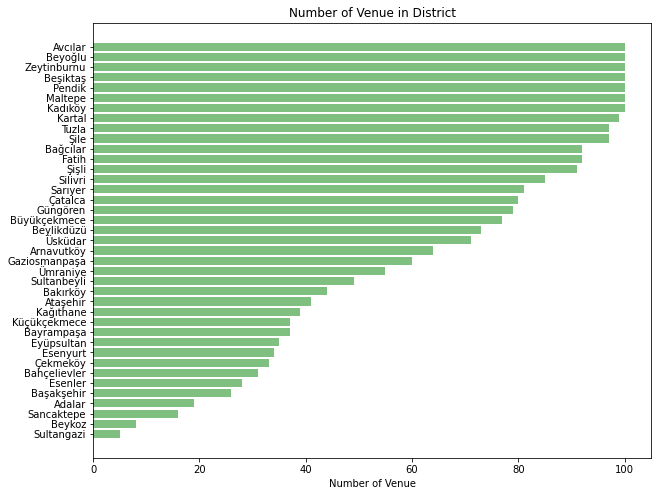

In [19]:
x = venue_groups.District
y = np.arange(len(x))
count = venue_groups.Count

plt.figure(figsize=(10,8))
plt.barh(y, count,align='center', color ='g', alpha=0.5)
plt.yticks(y, x)
plt.xlabel('Number of Venue')
plt.title('Number of Venue in District')

plt.show()

  As shown in the bar chart 7 districts which are Avcılar, Beyoğlu, Zeytinburnu, Beşiktaş, Pendik, Maltepe and Kadıköy reach 100 limit. 4 Districts - Adalar, Sancaktepe, Beykoz, Sultangazi- are below 20 venues and in the other districts number of venues change between 20 and 90.

We will analyze each district according to venues information.

In [20]:
ist_onehot = pd.get_dummies(ist_venues[['Venue Category']], prefix="", prefix_sep="")

ist_onehot['District'] = ist_venues['District']

list_column = ist_onehot.columns.tolist()

number_column = int(list_column.index('District'))

list_column = [list_column[number_column]] + list_column[:number_column] + list_column[number_column+1:]

ist_onehot = ist_onehot[list_column]

ist_onehot.head(10)

,District,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Candy Store,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Go Kart Track,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indie Movie Theater,Inn,Insurance Office,Internet Cafe,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Lighthouse,Lounge,Manti Place,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Office,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Piano Bar,Pide Place,Pie Shop,Piercing Parlor,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Söğüş Place,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Track,Trail,Train Station,Tram Station,Transportation Service,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,University,Vegetarian / Vegan Restaurant,Video Store,Volcano,Volleyball Court,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We will group rows by district and by taking the mean of the frequency of occurrence of each category.

In [21]:
istanbul_grouped = ist_onehot.groupby('District').mean().reset_index()
istanbul_grouped.head()

,District,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Bath House,Bathing Area,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Candy Store,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Classroom,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Fish Taverna,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,General Entertainment,General Travel,Gift Shop,Go Kart Track,Gourmet Shop,Gozleme Place,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indie Movie Theater,Inn,Insurance Office,Internet Cafe,Intersection,Italian Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Lighthouse,Lounge,Manti Place,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Mosque,Motorcycle Shop,Mountain,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Office,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Piano Bar,Pide Place,Pie Shop,Piercing Parlor,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Radio Station,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Steakhouse,Street Art,Supermarket,Surf Spot,Sushi Restaurant,Syrian Restaurant,Söğüş Place,Taco Place,Tattoo Parlor,Tea Room,Tennis Court,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Tourist Information Center,Track,Trail,Train Station,Tram Station,Transportation Service,Tree,Turkish Home Cooking Restaurant,Turkish Restaurant,Turşucu,University,Vegetarian / Vegan Restaurant,Video Store,Volcano,Volleyball Court,Water Park,Waterfront,Wedding Hall,Wine Bar,Wings Joint,Women's Store,Zoo Exhibit,Çöp Şiş Place
0,Adalar,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.0,0.00000,0.0,0.0,0.052632,0.052632,0.0,0.0,0.0,0.052632,0.000000,0.052632,0.00,0.0,0.00,0.0,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.157895,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['District']

for ind in np.arange(num_top_venues):
    
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
    
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = istanbul_grouped['District']

for ind in np.arange(istanbul_grouped.shape[0]):
    district_venues_sorted.iloc[ind, 1:] = return_most_common_venues(istanbul_grouped.iloc[ind, :], num_top_venues)

district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,Café,Scenic Lookout,Mountain,Bike Trail,Museum,Tennis Court,Beach,Bed & Breakfast,Surf Spot,University
1,Arnavutköy,Café,Dessert Shop,Restaurant,Coffee Shop,Steakhouse,Turkish Restaurant,Electronics Store,Fast Food Restaurant,Cafeteria,Kofte Place
2,Ataşehir,Café,Restaurant,Doner Restaurant,Coffee Shop,Steakhouse,Gym Pool,Bistro,Lounge,Bakery,Kebab Restaurant
3,Avcılar,Café,Gym / Fitness Center,Turkish Restaurant,Dessert Shop,Bar,Restaurant,Breakfast Spot,Pizza Place,Coffee Shop,Bistro
4,Bahçelievler,Park,Café,Restaurant,Trail,Middle Eastern Restaurant,Bakery,General Entertainment,Garden,Supermarket,Steakhouse


Let's cluster the district using the K-Means algorithm method.

In [24]:
kclusters = 4
istanbul_grouped_clustering = istanbul_grouped.drop('District', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(istanbul_grouped_clustering)
labels = kmeans.labels_
labels

array([2, 3, 2, 3, 0, 0, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 0, 0, 0, 0, 3, 2,
       0, 0, 2, 0, 2, 2, 2, 3, 1, 2, 0, 3, 0, 2, 3, 2, 2])

In [25]:
istanbul_merged = ist_data

istanbul_merged['Cluster Labels'] = kmeans.labels_

istanbul_merged = istanbul_merged.join(district_venues_sorted.set_index('District'), on='District')
istanbul_merged.head() 

,District,Population (2020),Area (km²),Density (per km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adalar,16033,11.05,1451,40.876259,29.091027,2,Café,Scenic Lookout,Mountain,Bike Trail,Museum,Tennis Court,Beach,Bed & Breakfast,Surf Spot,University
1,Arnavutköy,296709,450.35,659,41.184471,28.741245,3,Café,Dessert Shop,Restaurant,Coffee Shop,Steakhouse,Turkish Restaurant,Electronics Store,Fast Food Restaurant,Cafeteria,Kofte Place
2,Ataşehir,422594,25.23,16750,40.984749,29.106720,2,Café,Restaurant,Doner Restaurant,Coffee Shop,Steakhouse,Gym Pool,Bistro,Lounge,Bakery,Kebab Restaurant
3,Avcılar,436897,42.01,10400,40.980135,28.717547,3,Café,Gym / Fitness Center,Turkish Restaurant,Dessert Shop,Bar,Restaurant,Breakfast Spot,Pizza Place,Coffee Shop,Bistro
4,Bağcılar,737206,22.36,32970,41.033899,28.857898,0,Café,Gym,Coffee Shop,Dessert Shop,Hookah Bar,Turkish Restaurant,Music Venue,Jewelry Store,Burger Joint,Arcade


In [26]:
count_venue = istanbul_merged
count_venue = count_venue.drop(['District', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Café,Coffee Shop,Convenience Store,Cosmetics Shop,Gym,Hotel,Music Venue,Park,Seafood Restaurant,Turkish Restaurant
0,7,0,0,1,0,1,0,1,0,1
1,0,0,0,0,0,0,0,0,1,0
2,12,0,1,0,1,0,0,0,1,1
3,8,1,0,0,0,0,1,0,0,1


Text(0, 0.5, 'Number of Venue')

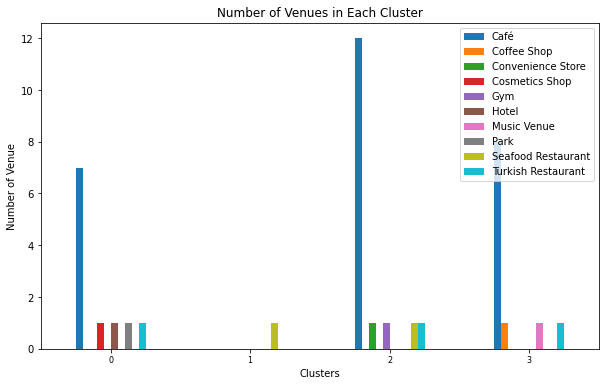

In [27]:

frame=cv_cluster.plot(kind='bar',figsize=(10,6))
plt.legend(labels=cv_cluster.columns,fontsize= 10)
plt.title("Number of Venues in Each Cluster",fontsize= 12)
plt.xticks(fontsize=8)
plt.xticks(rotation=0)
plt.xlabel('Clusters')
plt.ylabel('Number of Venue')

Now, we will analyze the housing sales prices for per square meter in İstanbul. 

In [28]:
df_districts.head()

,District,Population (2020),Area (km²),Density (per km²),Latitude,Longitude,Cluster Labels
0,Adalar,16033,11.05,1451,40.876259,29.091027,2
1,Arnavutköy,296709,450.35,659,41.184471,28.741245,3
2,Ataşehir,422594,25.23,16750,40.984749,29.106720,2
3,Avcılar,436897,42.01,10400,40.980135,28.717547,3
4,Bağcılar,737206,22.36,32970,41.033899,28.857898,0


In [29]:
avg_price_data = pd.read_csv('Avg_House_Sales_Price.csv')
avg_price_data.head()

,District,Avg House Sales Price (TL/m2)
0,Adalar,10676
1,Arnavutköy,3684
2,Ataşehir,6303
3,Avcılar,4023
4,Bağcılar,4236


In [30]:
df_districts = df_districts.merge(avg_price_data, how='inner', on='District')
df_districts.head()

,District,Population (2020),Area (km²),Density (per km²),Latitude,Longitude,Cluster Labels,Avg House Sales Price (TL/m2)
0,Adalar,16033,11.05,1451,40.876259,29.091027,2,10676
1,Arnavutköy,296709,450.35,659,41.184471,28.741245,3,3684
2,Ataşehir,422594,25.23,16750,40.984749,29.106720,2,6303
3,Avcılar,436897,42.01,10400,40.980135,28.717547,3,4023
4,Bağcılar,737206,22.36,32970,41.033899,28.857898,0,4236


In [31]:
df_house = avg_price_data.sort_values('Avg House Sales Price (TL/m2)').reset_index(drop=True)

df_house.head()

,District,Avg House Sales Price (TL/m2)
0,Esenyurt,2875
1,Esenler,3090
2,Sultangazi,3125
3,Silivri,3252
4,Çatalca,3294


We will divide the average house sales prices into 3 groups as low level, medium level, and high level, and create a histogram to see the results.

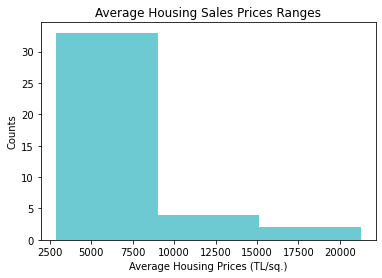

In [32]:
num_bins = 3
n, bins, patches = plt.hist(df_house['Avg House Sales Price (TL/m2)'], num_bins, facecolor='#0ea7b5', alpha =0.6)
plt.title("Average Housing Sales Prices Ranges",fontsize= 12)
plt.xticks(fontsize=10)
plt.xlabel('Average Housing Prices (TL/sq.)', fontsize=10)
plt.ylabel('Counts', fontsize=10)
plt.show()

As shown in the histogram, the average house sales price below 9000 represents the low level, 9000 to 15000 the mid-level, and above the 15000 the high level.

Let's add a Level Labels column to show average house sales price levels.

In [33]:
level = []
for i in range(0,len(df_house)):
    if (df_house['Avg House Sales Price (TL/m2)'][i] < 9000):
        level.append("Low Level House Price")
    elif (df_house['Avg House Sales Price (TL/m2)'][i] >= 9000 and df_house['Avg House Sales Price (TL/m2)'][i] < 15000):
        level.append("Mid Level House Price")
    else:
        level.append("High Level House Price")
        
df_house['Level_labels'] = level
df_house.head()

,District,Avg House Sales Price (TL/m2),Level_labels
0,Esenyurt,2875,Low Level House Price
1,Esenler,3090,Low Level House Price
2,Sultangazi,3125,Low Level House Price
3,Silivri,3252,Low Level House Price
4,Çatalca,3294,Low Level House Price



Let's group each district by the number of top 3 venues. 

In [38]:
top3 = ist_venues.groupby(['District','Venue Category']).size().reset_index(name='Counts')
top3 = top3.sort_values(['District','Counts'],ascending=False).groupby('District').head(3).reset_index(drop=True)
top3['Combine'] = top3['Counts'].map(str) + " " + top3['Venue Category']
top3 = top3.groupby(['District'])['Combine'].apply(",".join).reset_index()
top3.head()

,District,Combine
0,Adalar,"3 Café,2 Mountain,2 Scenic Lookout"
1,Arnavutköy,"12 Café,3 Dessert Shop,3 Restaurant"
2,Ataşehir,"5 Café,5 Restaurant,3 Coffee Shop"
3,Avcılar,"27 Café,4 Bar,4 Dessert Shop"
4,Bahçelievler,"3 Park,2 Café,2 Restaurant"


Let's merge all variables in the result dataframe.

In [39]:
result = pd.merge(istanbul_merged, top3[['District', 'Combine']], left_on = 'District',right_on = 'District',how = 'left')

result = pd.merge(result, df_house[['District', 'Level_labels']],left_on = 'District', right_on = 'District', how = 'left')


result.head()

,District,Population (2020),Area (km²),Density (per km²),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Combine,Level_labels
0,Adalar,16033,11.05,1451,40.876259,29.091027,2,Café,Scenic Lookout,Mountain,Bike Trail,Museum,Tennis Court,Beach,Bed & Breakfast,Surf Spot,University,"3 Café,2 Mountain,2 Scenic Lookout",Mid Level House Price
1,Arnavutköy,296709,450.35,659,41.184471,28.741245,3,Café,Dessert Shop,Restaurant,Coffee Shop,Steakhouse,Turkish Restaurant,Electronics Store,Fast Food Restaurant,Cafeteria,Kofte Place,"12 Café,3 Dessert Shop,3 Restaurant",Low Level House Price
2,Ataşehir,422594,25.23,16750,40.984749,29.106720,2,Café,Restaurant,Doner Restaurant,Coffee Shop,Steakhouse,Gym Pool,Bistro,Lounge,Bakery,Kebab Restaurant,"5 Café,5 Restaurant,3 Coffee Shop",Low Level House Price
3,Avcılar,436897,42.01,10400,40.980135,28.717547,3,Café,Gym / Fitness Center,Turkish Restaurant,Dessert Shop,Bar,Restaurant,Breakfast Spot,Pizza Place,Coffee Shop,Bistro,"27 Café,4 Bar,4 Dessert Shop",Low Level House Price
4,Bağcılar,737206,22.36,32970,41.033899,28.857898,0,Café,Gym,Coffee Shop,Dessert Shop,Hookah Bar,Turkish Restaurant,Music Venue,Jewelry Store,Burger Joint,Arcade,"18 Café,7 Gym,5 Coffee Shop",Low Level House Price


Finally, let's visualize the results using Folium library.

In [36]:
# create map\n",
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters\n",
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map\n",
markers_colors = []
for lat, lon, poi, join, cluster_number, label in zip(result['Latitude'], result['Longitude'], result['District'], result['Join'], result['Cluster Labels'], result['Level_labels']):
    label = folium.Popup(str(poi) + " / "  + str(label) + " / " + str(join), parse_html=True)
    folium.CircleMarker([lat, lon],radius=4, color= rainbow[cluster_number-1],popup=label,
                        fill_color = rainbow[cluster_number-1],fill_opacity=1, fill=True).add_to(map_clusters)

map_clusters

## Discussion

In this study, average house sales prices for 39 districts of Istanbul were examined. Also, the venues were explored to understand the social structures of the district and to have an idea about the possibilities they offer.

Clustering work has been done for venues in each district using the K-means algorithm. In this work, the radius is determined as 500 meters. This reduces the quality of the study. Different values to be used will affect the result. Also, the value of k was chosen as 4. When the optimum k value is calculated with different methods, the accuracy of the study can increase.

A clustering study has been carried out on average house sales prices. It is divided into 3 clusters as low level, medium level, and high level. It is seen as a result of the study that the price ranges of these clusters are wide. Increasing the number of clusters and lowering the price ranges will increase the quality of the study.

## Conclusion

As mentioned before, Istanbul is a city that receives a lot of immigration. The range of income distribution in Istanbul is wide and it affects the structure of the districts. People who intend to settle in Istanbul and own a house can benefit from these and similar studies while determining the districts that are suitable for their social life and budget.